In [31]:
import numpy as np
from dlm_functions import forwardFilteringM, Model, plotThFig,plotThFig2

import numpy as np
import scipy.linalg
from scipy.stats import t as tdstr
from scipy.stats import norm
from scipy.interpolate import interp1d
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib
matplotlib.rc('font', size=14)
import matplotlib.pyplot as plt


In [33]:
def calDrift(ts,window):
    qv = (np.nanmax(ts)-np.nanmin(ts))/20
    delta = (np.nanmax(ts)-np.nanmin(ts))/10
    trd_diffusion = (np.nanmax(ts)-np.nanmin(ts))/20
    drift = np.zeros([len(ts)-window-1,1])
    
    for i in range(drift.shape[0]):
        subn = ts[i:i+window]
        DX = subn[1:]-subn[:-1]
        X1 = subn[:-1]
        xq = np.arange(np.nanmin(ts)-0.1*abs(np.nanmin(ts)),np.nanmax(ts)+0.1*abs(np.nanmax(ts)),qv)
        mx = np.zeros(xq.shape)+np.nan
        mx2 = np.zeros(xq.shape)+np.nan
        for j in range(len(xq)):
            tmp = DX[np.abs(X1-xq[j])<delta]
            if len(tmp)>0:
                mx[j] = np.nanmedian(tmp)
                mx2[j] = np.nanmedian(tmp**2)
        idx = [j for j,x in enumerate(mx2) if x<trd_diffusion]
        idx = [j for j in idx if np.isfinite(mx[j])] # remove nan
        if np.size(idx):            
            drift[i] = 1+np.polyfit(xq[idx],mx[idx],1)[0] # slope of <D(x)_1> v.s. x
        else:
            drift[i] = 0
    return drift

def calEmprAC(nn,window):
    empr_ac = np.zeros([len(nn)-window-1,1])
    for i in range(len(empr_ac)):
        t1 = nn[i:i+window]
        t2 = nn[i+1:i+window+1]
        idx = [j for j in range(len(t1)) if np.isfinite(t1[j]+t2[j])]
        if np.size(idx):
            empr_ac[i] = np.corrcoef(t1[idx],t2[idx])[0,1]
        else:
            empr_ac[i] = 0
    return empr_ac

def calEmprVar(nn,window):
    return np.asarray([np.nanstd(nn[i:i+window]) for i in range(len(nn)-window)])


In [16]:
# 参数设置

# dd 贴现因子 δ(参见方法)控制状态向量θt随机变化的幅度. 
# δ = 1 对应于无随机变化. 较小的 δ 允许更大的随机变化,导致自相关时间序列波动更大,不确定性范围更宽
dd = 0.98 
TimeofChange = 600
x0 = 0.5 
N = 1000
np.random.seed(88) 

a = 0.5
b = 4
gamma = 0.2

print('Exp. 1: theoretical AC: %.3f' % np.exp(-gamma*(b-a)))

Exp. 1: theoretical AC: 0.497


In [18]:
# 数据准备
#%% non-linear dynamics with white noise
X = np.array([x0])
for i in range(N):
    xt = X[-1]
    if i<TimeofChange:
        b = 4
    else:
        b = 2
    dx = gamma*(xt-a)*(xt-b)
    noise = 0.05*np.random.normal(0,1)
    X = np.concatenate([X,[xt+dx+noise]])
    
meanX = np.mean(X); X = X-meanX # 数据中心化
Y = X[1:] # Y为1:
XX = np.column_stack([X[:-1]]) #X 为:-1

In [19]:
rseas = []
M = Model(Y,XX,rseas,dd)

# Y 为预测变量
# XX 为预测变量



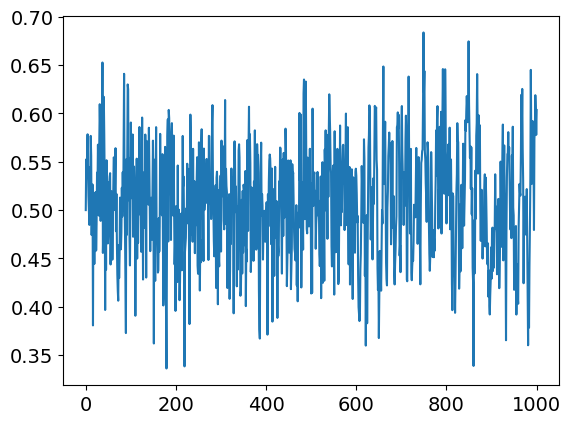

In [21]:
X = np.array([x0])
for i in range(N):
    xt = X[-1]
    if i<TimeofChange:
        b = 4
    else:
        b = 2
    dx = gamma*(xt-a)*(xt-b)
    noise = 0.05*np.random.normal(0,1)
    X = np.concatenate([X,[xt+dx+noise]])
plt.plot(X)

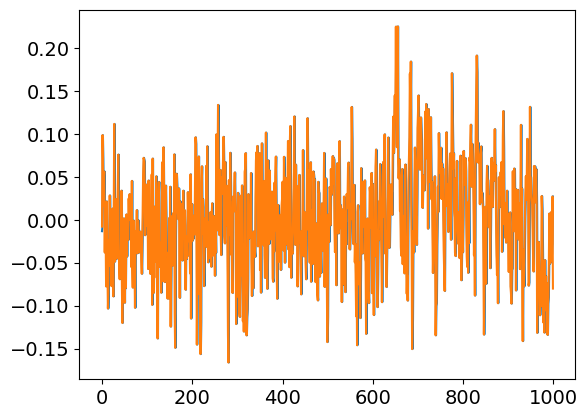

In [23]:
plt.plot(XX)
plt.plot(Y)

In [34]:
FF = forwardFilteringM(M)
FF

{'sm': array([[ 0.00000000e+00, -7.81125839e-03,  9.18271966e-02, ...,
         -2.19913896e-02, -1.91242529e-02, -2.37913848e-02],
        [ 0.00000000e+00, -3.90562920e-03,  8.94340762e-02, ...,
         -2.23764626e-04, -1.91940642e-04, -2.36617263e-04],
        [ 0.00000000e+00,  5.19810583e-05,  2.03247216e-03, ...,
          5.64934420e-01,  5.69041201e-01,  5.39349744e-01]]),
 'sC': array([[[ 0.00000000e+00,  2.94039799e-02,  2.24414926e-02, ...,
           1.13464212e-04,  1.15360665e-04,  1.15718637e-04],
         [ 0.00000000e+00,  1.47019900e-02,  2.01759311e-02, ...,
           1.15251075e-06,  1.16862440e-06,  1.17100655e-06],
         [ 0.00000000e+00,  9.93839134e-03,  5.37442502e-03, ...,
           5.05756984e-04,  5.13280718e-04,  4.80050073e-04]],
 
        [[ 0.00000000e+00,  1.47019900e-02,  2.01759311e-02, ...,
           1.15251075e-06,  1.16862440e-06,  1.17100655e-06],
         [ 0.00000000e+00,  3.88065603e-01,  3.85743435e-02, ...,
           2.12680754e-08, 

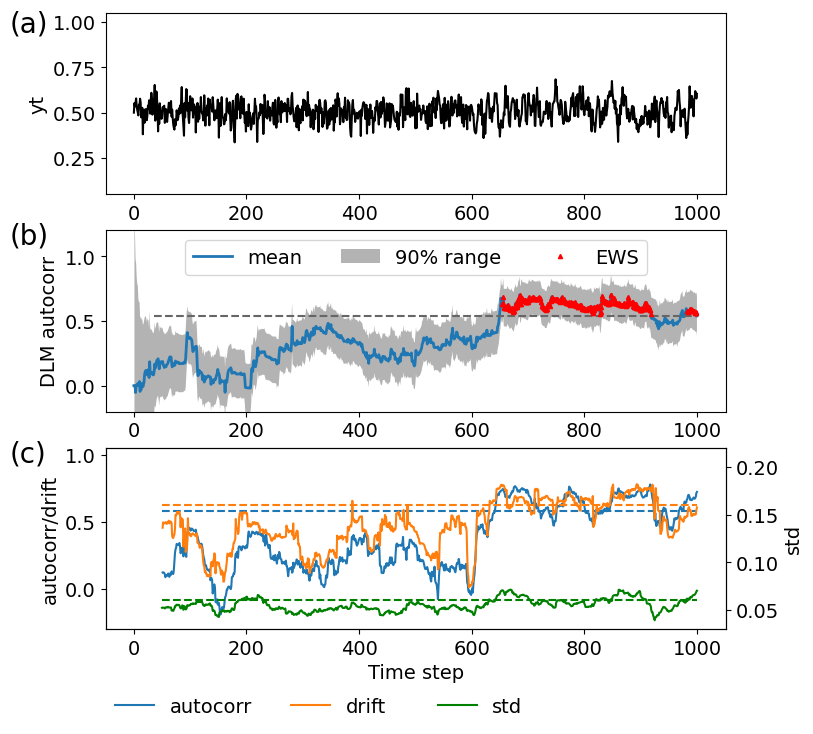

In [35]:
## 模型求解
FF = forwardFilteringM(M)

plotThFig(FF,X,meanX)

NameError: name 'calEmprVar' is not defined

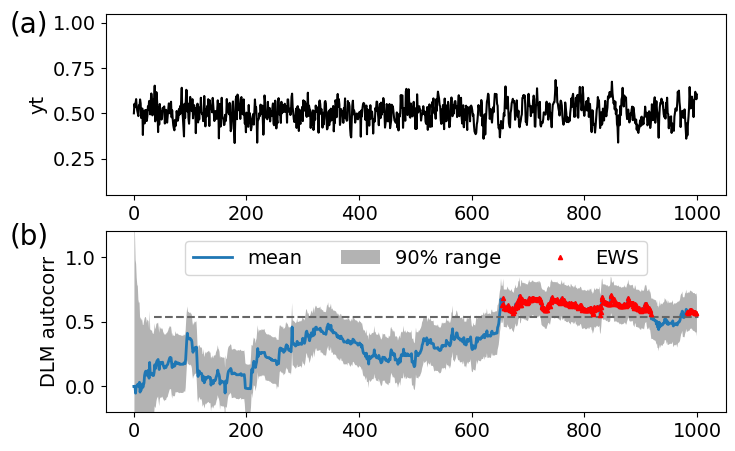

In [30]:
warmup = int(24*1.5)
quantile = 0.90
vid = 2

sm = FF.get('sm')[vid,:]
sC = np.sqrt(FF.get('sC')[vid,vid,:]) # std
snu = FF.get('snu')


bd = list(map(lambda m,C,nu: m+C*tdstr.ppf(quantile,nu),
                    sm,sC,snu))
mbd = np.median(bd[warmup:])
ews = np.array([i for i,im in enumerate(sm) if im >mbd])
ews = ews[ews>warmup]
ews_continuous = []
for i in range(len(ews)): # if ews lasts > 3 mon
    tile = [j for j in ews if (j<=ews[i] and j>=ews[i]-5)]
    if len(tile)>4:
        ews_continuous = np.concatenate([ews_continuous,[ews[i]]])
ews_continuous = np.array(ews_continuous).astype(int)

xpos = -220
xlim = [-0.05*len(X),len(X)*1.05]
plt.figure(figsize=(8, 8))
ax1 = plt.subplot(311)
ax1.plot(X+meanX,'-k')
ax1.set_ylim([0.05,1.05])
ax1.set_xlim(xlim)
ax1.set_ylabel('yt')
ax1.text(xpos, 0.95, '(a)',fontsize=20)

steps = np.arange(len(sm))
ax2 = plt.subplot(3,1,2)
ax2.plot(steps,sm,lw=2, label='mean')
ax2.fill_between(steps,2*sm-bd, bd, facecolor='0.7',label=str(int(quantile*100))+'% range')
ax2.plot([warmup,len(sm)],[mbd,mbd],'--',color='0.4')
ax2.plot(steps[ews_continuous],sm[ews_continuous],'^r',markersize=3,label='EWS')

ax2.set_ylim([-0.2,1.2])
ax2.set_xlim(xlim)
ax2.set_ylabel('DLM autocorr')
ax2.legend(loc=9,ncol=3)
ax2.text(xpos, 1.1, '(b)',fontsize=20)

window = 50
emprAc = calEmprAC(X,window)
Drift = calDrift(X,window)
emprVar = calEmprVar(X,window)


ax3 = plt.subplot(3,1,3)
ax4 = ax3.twinx()
nv = norm.ppf(0.8)
l1 = ax3.plot(steps[window+1:],emprAc,label='autocorr')
ax3.plot([steps[window],steps[-1]],np.nanmean(emprAc)+nv*np.nanstd(emprAc)*np.array([1,1]),'--',color=l1[0].get_color())
l2 = ax3.plot(steps[window+1:],Drift,label='drift')
ax3.plot([steps[window],steps[-1]],np.nanmean(Drift)+nv*np.nanstd(Drift)*np.array([1,1]),'--',color=l2[0].get_color())

ax3.set_xlabel('Time step')
ax3.set_ylabel('autocorr/drift')
ax3.set_xlim(xlim)
ax3.set_ylim([-0.3,1.05])
l3 = ax4.plot(steps[window:],emprVar,'-g',label='std')
ax4.plot([steps[window],steps[-1]],np.nanmean(emprVar)+nv*np.nanstd(emprVar)*np.array([1,1]),'--',color=l3[0].get_color())
ax4.set_ylabel('std')
ax4.set_ylim([0.03,0.22])

leg3 = ax3.legend(bbox_to_anchor=(0.48, -0.28),ncol=2,)
leg4 = ax4.legend(bbox_to_anchor=(0.7, -0.28))
leg3.get_frame().set_linewidth(0.0)
leg4.get_frame().set_linewidth(0.0)
ax3.text(xpos, 0.95, '(c)',fontsize=20)

Exp. 2


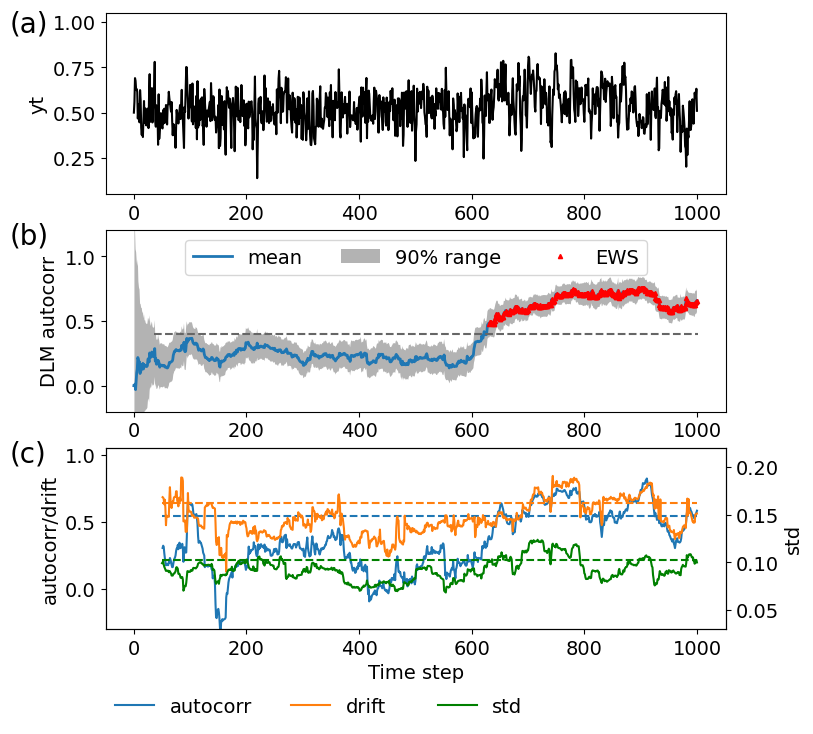

In [5]:
#%% non-linear dynamics with random forcing and white noise
np.random.seed(88) 
a = 0.5
b = 4
gamma = 0.2
print('Exp. 2')

X = np.array([x0])
Forcing = 0.07*np.random.normal(0,1,N)
Noise = 0.05*np.random.normal(0,1,N)
np.random.seed(11) # 88
for i in range(N):
    xt = X[-1]
    if i<TimeofChange:
        b = 4
    else:
        b = 2
    dx = gamma*(xt-a)*(xt-b)
    X = np.concatenate([X,[xt+dx+Noise[i]+Forcing[i]]])


rseas = []
meanX = np.mean(X); X = X-meanX
Y = X[1:]
XX = np.column_stack(([X[:-1],Forcing]))
M = Model(Y,XX,rseas,dd)
FF = forwardFilteringM(M)

plotThFig(FF,X,meanX)

In [38]:
Forcing

NameError: name 'Forcing' is not defined

Exp. 3


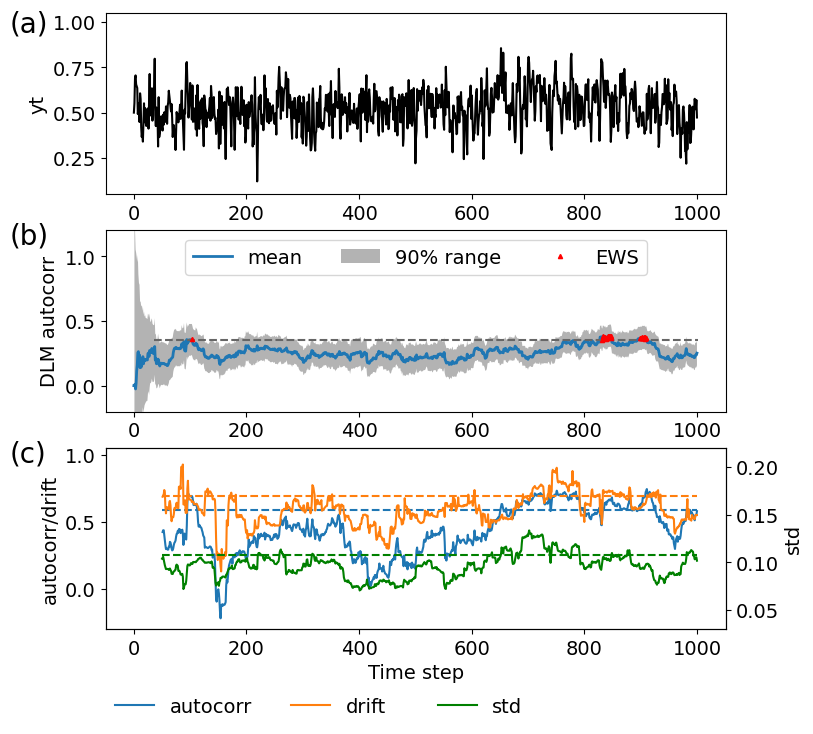

In [6]:
#%% non-linear dynamics with auto-correlated forcing and white noise
np.random.seed(88) 
a = 0.5
b = 4
print('Exp. 3')

X = np.array([x0])
eps = 0.07*np.random.normal(0,1,N)
Forcing = np.zeros(eps.shape)
Noise = 0.05*np.random.normal(0,1,N)
np.random.seed(11) # 88
for i in range(N):
    xt = X[-1]
    if i<TimeofChange:
        b = 4
        forcingac = 0.2
    else:
        b = 4
        forcingac = 0.6
    if i>0:
        Forcing[i] = eps[i]+ Forcing[i-1]*forcingac
    dx = gamma*(xt-a)*(xt-b)
    X = np.concatenate([X,[xt+dx+Noise[i]+Forcing[i]]])



rseas = []; 
meanX = np.mean(X); X = X-meanX
Y = X[1:]
XX = np.column_stack(([X[:-1],Forcing]))
M = Model(Y,XX,rseas,dd)
FF = forwardFilteringM(M)

plotThFig(FF,X,meanX)

Exp. 4


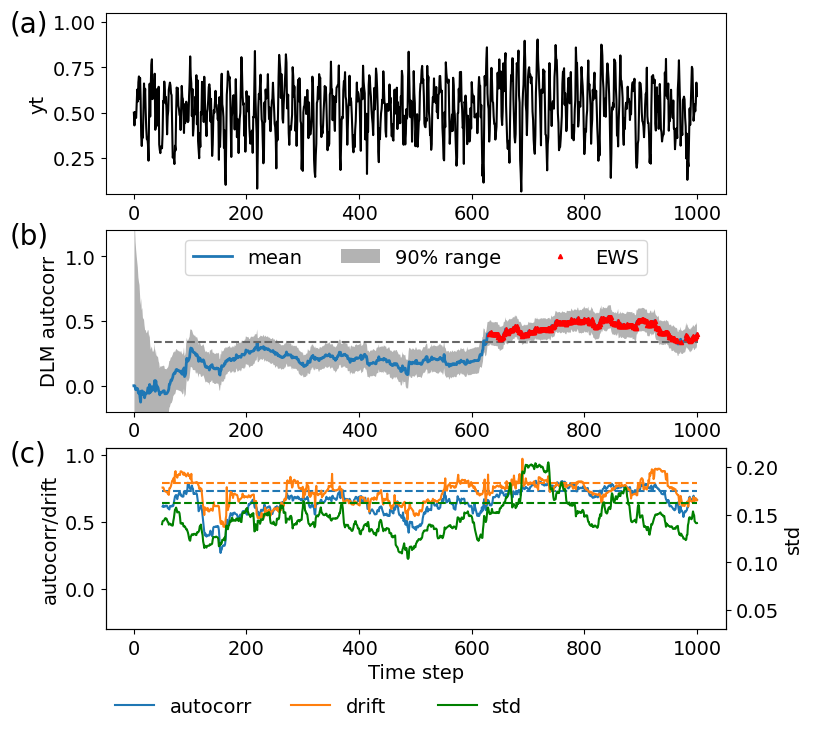

In [7]:
#%% non-linear dynamics with seasonal component in Y, random forcing
np.random.seed(88) 
a = 0.5
b = 4
gamma = 0.2
AC = np.exp(-gamma*(b-a))
print('Exp. 4')

period = 365.25/16

X = np.array([x0])
Forcing = 0.07*np.random.normal(0,1,N)
Noise = 0.05*np.random.normal(0,1,N)
Seas = [0.05*np.sin(2*np.pi/period*(i-6))+0.1*np.sin(2*np.pi/(period/2)*(i-4)) for i in range(N)]
np.random.seed(11) # 88
for i in range(N):
    xt = X[-1]
    if i<TimeofChange:
        b = 4
    else:
        b = 3
    dx = gamma*(xt-a)*(xt-b)
    X = np.concatenate([X,[xt+dx+Noise[i]+Forcing[i]+Seas[i]]])



rseas = [1,2]
meanX = np.mean(X); X = X-meanX
Y = X[1:]
XX = np.column_stack(([X[:-1],Forcing]))
M = Model(Y,XX,rseas,dd)
FF = forwardFilteringM(M)

plotThFig(FF,X,meanX)

Exp. 5


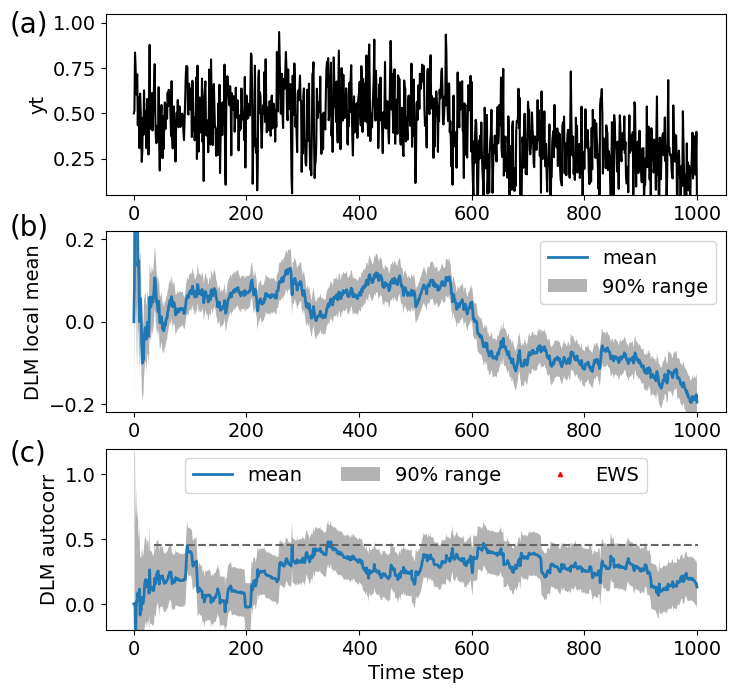

In [8]:
#%% non-linear dynamics with sudden decrease in Y, random forcing
np.random.seed(88) 
a = 0.5
b = 4
gamma = 0.2
print('Exp. 5')

X = np.array([x0])
Noise = 0.15*np.random.normal(0,1,N)
delta = 0.25

for i in range(N):
    xt = X[-1]
    if i<TimeofChange:
        dx = gamma*(xt-a)*(xt-b)
    else:
        dx = gamma*(xt-(a-delta))*(xt-(b-delta))

    X = np.concatenate([X,[xt+dx+Noise[i]]])

rseas = []
meanX = np.mean(X); X = X-meanX
Y = X[1:]
XX = np.column_stack(([X[:-1]]))
M = Model(Y,XX,rseas,dd)
FF = forwardFilteringM(M)

warmup = int(24*1.5)
quantile = 0.90

plotThFig2(FF,X,meanX)

Exp. 6


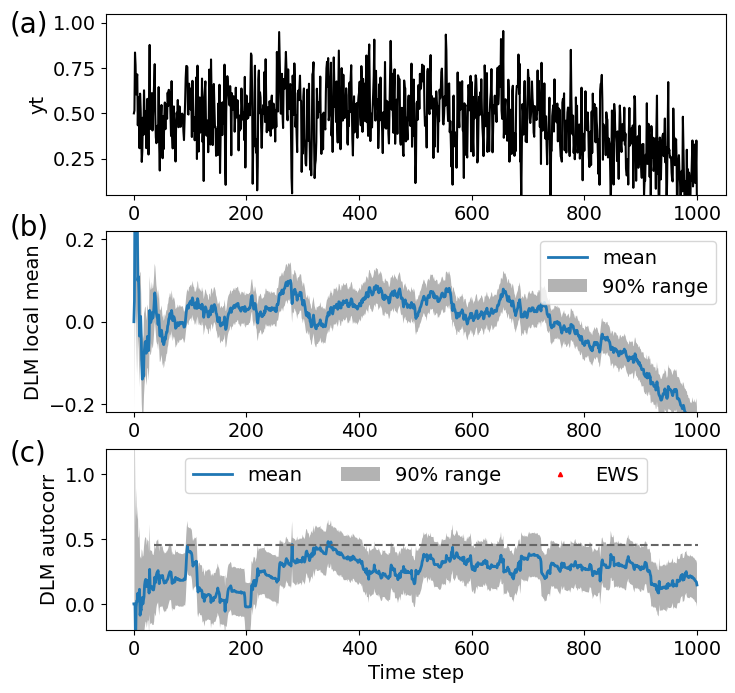

In [9]:
#%% non-linear dynamics with a decreasing trend in Y, random forcing
np.random.seed(88) 
a = 0.5
b = 4
gamma = 0.2
print('Exp. 6')

X = np.array([x0])
Noise = 0.15*np.random.normal(0,1,N)
deltaN = N-TimeofChange
delta = 0.3/deltaN

for i in range(N):
    xt = X[-1]
    if i<TimeofChange:
        dx = gamma*(xt-a)*(xt-b)
    else:
        dx = gamma*(xt-(a-delta*(i-TimeofChange)))*(xt-(b-delta*(i-TimeofChange)))

    X = np.concatenate([X,[xt+dx+Noise[i]]])


rseas = []
meanX = np.mean(X); X = X-meanX
Y = X[1:]
XX = np.column_stack(([X[:-1]]))
M = Model(Y,XX,rseas,dd)
FF = forwardFilteringM(M)

plotThFig2(FF,X,meanX)

